# [IDEA 제공한 사이트](https://medium.com/jungle-book/towards-data-set-augmentation-with-gans-9dd64e9628e6)

# Modification
* [google wasserstein dist 추가](https://github.com/google/wasserstein-dist/blob/master/train.py)
* variable_scope 추가
* 수정한 Loss 방식 문제 확인 후 다시 원래대로
* tf.nn.moments 를 활용하여 평균, 분산 구해서 통계량값이 맞도록 처리

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from jupyter_tensorboard import *
from utility import *
from Init import *
from wasserstein import Wasserstein
from IPython.display import clear_output
churn = pd.read_csv("./../Data/Churn.csv")


    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


In [2]:
churn.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
churn.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [4]:
Real = churn[["state", "international plan" , 'total day charge' , 'total eve charge' ,  'total intl calls','total night calls' ,  'total day calls' , 'churn' , 'area code']]

https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

```
## all float 
df.select_dtypes(include=['floating'])
## all integer
df.select_dtypes(include=['integer'])
## all numeric
df.select_dtypes(include=['number'])
## select
[col for col in df.columns.tolist() if df[col].dtype not in ['object','<M8[ns]']]
```

In [5]:
Real.dtypes

state                  object
international plan     object
total day charge      float64
total eve charge      float64
total intl calls        int64
total night calls       int64
total day calls         int64
churn                    bool
area code               int64
dtype: object

## PostProcessing


* Numeric
    * Inverse Transform을 진행해서 원래 분포의 범위로 변환시켜주기
    * **integer**
        * count variable 같은 경우 round로 정수형으로 처리해주기?
    * **numeric**
        * 그대로 사용해도 가능 할 듯
* Categorical
    * softmax로 나오므로 argmax 처리하고, 분포를 보여줄때는 수치형으로 보여주고 사용할 때는 변환하는 방식
    * 일단 그림을 그릴 때는 그대로 사용하면 될 듯

In [6]:
Int_name = Real.select_dtypes(include= ["integer"]).columns.tolist()
object_name = Real.select_dtypes(exclude= ["number"]).columns.tolist()
numeric_name = Real.select_dtypes(include= ["number"]).columns.tolist()

object_name.append("area code")
numeric_name.remove("area code")
Int_name = list(set(Int_name) - set(object_name))
print("NUMERIC : " ,numeric_name)
print("OBJECT : ", object_name)
print("Int : ",Int_name)

NUMERIC :  ['total day charge', 'total eve charge', 'total intl calls', 'total night calls', 'total day calls']
OBJECT :  ['state', 'international plan', 'churn', 'area code']
Int :  ['total day calls', 'total night calls', 'total intl calls']


In [7]:
Real = Real[numeric_name + object_name ]

In [8]:
feature = Real.columns.tolist()

In [9]:
total_length = 0 
info = {}
for i in object_name :
    value = Real[i].nunique()
    info[i] = value
    total_length += value
    
total_length += len(numeric_name)
print(total_length)
print(info)

63
{'state': 51, 'international plan': 2, 'churn': 2, 'area code': 3}


In [10]:
info.get("state")

51

In [11]:
data = Real.values
def sample_data(n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

In [12]:
input_dim = np.shape(data)[1] 
latet_dim = 20
BATCH_SIZE = 50
def generator(Z , batch_size , hsize=[ 50, 80 , 100],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=None)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=None) 
        h2 = tf.layers.dense(h2, hsize[2] , activation = tf.nn.leaky_relu , use_bias=True )  
        #num = tf.slice(h2 , [0,0] , [BATCH_SIZE, 22] )  # 
        #cat = tf.slice(h2 , [0,22] , [BATCH_SIZE, 3] ) # 
        out = tf.layers.dense(h2,  total_length , activation = None , use_bias= True )
        num = tf.slice(out , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        first = tf_sqnl(num)
        ## Categorcial 
        NUM = 0
        for i in object_name :
            cat = tf.slice(out , [0,len(numeric_name) + NUM ] , [batch_size , info.get(i)] ) # 
            Species = tf.nn.softmax(cat)
            NUM += info.get(i)
            first = tf.concat([first , Species], axis = 1 , name = i[0] )
        #out = tf.layers.dense(num ,input_dim , activation = tf_sqnl , use_bias=False , name = 'Numerical' )  # activation=None 
    return first


def discriminator(X,hsize=[70, 40],reuse=True):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu , name = "D1")
        #h1 = minibatch(h1 , name = "D1")
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu , name = "D2" )
        h2 = minibatch(h2 , name = "D2")
        h3 = tf.layers.dense(h2,10 ,activation=tf.nn.leaky_relu , name = "D3" )
        #h3 = minibatch(h3 , name = "D3")
        out = tf.layers.dense(h3,1) # activation=None OUTPUT
    return out, h3

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])


In [13]:
input_dim

9

In [14]:
tf.reset_default_graph()
BATCH_SIZE = 50
X = tf.placeholder(tf.float32,[None, total_length  ], name= "X")
Z = tf.placeholder(tf.float32,[None,latet_dim ] , name = "Z")
batch_size = tf.placeholder(tf.int64, name="Batchsize")

In [15]:
EPOCHS = 20000
BATCH_SIZE = 50
data_len = np.shape(data)[0]
batch_iter = int(data_len / BATCH_SIZE)

dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size , drop_remainder=True ).repeat().shuffle(1000)
iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

print(batch_iter)

Instructions for updating:
Colocations handled automatically by placer.
66


In [16]:
G_sample = generator(z , batch_size)
r_logits, r_rep = discriminator(x,reuse=False)
f_logits, g_rep = discriminator(G_sample,reuse=True)

# e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
# x_hat =  e * x + (1-e) * G_sample
# grad  = tf.gradients( discriminator(x_hat,reuse=True ), x_hat)[0]

#grad_norm = tf.norm( tf.layers.flatten(grad) , axis = 1)
#LP = 10 * tf.reduce_mean( tf.square( tf.maximum(0.0 ,grad_norm - 1.0)))


# slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
# gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

Instructions for updating:
Use keras.layers.dense instead.


In [17]:
# fake_logit = (f_logits - tf.reduce_mean(r_logits))
# real_logit = (r_logits - tf.reduce_mean(f_logits))
# real_logit = tf.sigmoid( real_logit )
# fake_logit = tf.sigmoid( fake_logit )
# disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
# gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))


# disc_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)) , name = "discriminator_loss")
# gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)), name= "generator_loss")

## wgan Loss 변경
### 이유 : 이전에는 이미지다보니 2D 전체를 하는 것이 맞지만, 테이블 데이터 같은 경우에는 열별로 비교해야할듯하다.
### 이유2 : 전체적인 것도 고려할 수 있게하기! 
e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
x_hat =  e * x + (1-e) * G_sample
grad  = tf.gradients( discriminator(x_hat, reuse=True ), x_hat)[0]
slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

fake_logit = (f_logits - tf.reduce_mean(r_logits))
real_logit = (r_logits - tf.reduce_mean(f_logits))
real_logit = tf.sigmoid( real_logit )
fake_logit = tf.sigmoid( fake_logit )

with tf.variable_scope("Discriminator_Loss") :        
#     total_disc_loss = tf.reduce_mean(f_logits) - tf.reduce_mean(r_logits)     
#     col_disc_loss = tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ) - tf.reduce_mean(r_logits , axis = 0  ))
#     ratio = 1.0
#     disc_loss = ratio * total_disc_loss + (1-ratio) * col_disc_loss 
    disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
    disc_loss += gradient_penalty

## 기존 wgan loss
#disc_loss = tf.reduce_mean(f_logits  ) - tf.reduce_mean(r_logits  ) + gradient_penalty
#gen_loss  = - tf.reduce_mean(f_logits)


## Numeric 변수에 대한 Correlation Loss 추가
### 이유는 상관관계가 유사하게 나와야 하기 때문에 규제를 주는 역할을 기대할 수 있다!
### Generator Loss에 넣어서 Generator에서만 Weight 조절할수 있게! 
def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=0, keep_dims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

with tf.variable_scope("Generator_Loss"):
    with tf.variable_scope("Original_Loss"):
        gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))
        #gen_loss  = - tf.reduce_mean(f_logits)
        # -tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ))
    with tf.variable_scope("Corr_Loss"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        corr_loss = tf.reduce_mean(tf.square( tf.div( tf_cov(num_G) - tf_cov(num_R) , 2 ) ))        
    gen_loss += 5*corr_loss
    with tf.variable_scope("wasserstein_Loss"):
        wasserstein = Wasserstein(G_sample, x , BATCH_SIZE)
        loss = wasserstein.dist(C=0.1, nsteps=10)
    gen_loss += loss
    with tf.variable_scope("Stat"):
        Gcol_mean , Gcol_var = tf.nn.moments(G_sample , axes = [0])
        Xcol_mean , Xcol_var = tf.nn.moments(x , axes = [0])
        G_mean , G_var = tf.nn.moments(G_sample , axes = [0,1])
        X_mean , X_var = tf.nn.moments(x , axes = [0,1])
        Colstat = tf.reduce_mean(tf.square(Gcol_mean - Xcol_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(Gcol_var) - tf.sqrt(Xcol_var)))
        Totalstat = tf.reduce_mean(tf.square(G_mean - X_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(G_var) - tf.sqrt(X_var)))
    gen_loss += Colstat
    gen_loss += Totalstat


tf.summary.scalar("Dloss", disc_loss)
tf.summary.scalar("Gloss", gen_loss)

t_vars = tf.trainable_variables()

for var in t_vars :
    tf.summary.histogram(var.op.name, var)

global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
lr = 0.001
learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.98, staircase=True , )

tf.summary.scalar("learning_rate", learning_rate)
with tf.variable_scope("Optimizer"):
    gen_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(gen_loss,var_list = gen_vars) # G Train step
    disc_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(disc_loss,var_list = disc_vars) # D Train step
    

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
tensorboard()

In [19]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
merged_summary = tf.summary.merge_all()
sess = tf.Session(config= config)
saver = tf.train.Saver()

suumary_dir = "/home/advice/Python/SR/board/Gan_Chrun_Result"
try :
    if tf.gfile.Exists(suumary_dir):
        tf.gfile.DeleteRecursively(suumary_dir)
        tf.gfile.MakeDirs(suumary_dir)
        tf.gfile.DeleteRecursively("./gan_Chrun_result")
        tf.gfile.MakeDirs("./gan_Chrun_result")
except Exception as e :
    tf.gfile.MakeDirs("./gan_Chrun_result")
    
    
writer = tf.summary.FileWriter(suumary_dir)
writer.add_graph(sess.graph )
tf.global_variables_initializer().run(session=sess)

In [20]:
load_model = False
if load_model == True :
    print("학습된 모델 사용하기")
    save_file = "./savemodel/gan.meta"
    saver = tf.train.import_meta_graph(save_file)
    saver.restore(sess, tf.train.latest_checkpoint('./savemodel/'))
else :
    print("처음부터 학습시키기")

처음부터 학습시키기


In [21]:
original = data.copy()

In [22]:

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
##
TOTAL = data[:,:len(numeric_name)]
onehot_bin = []
for i in range(len(numeric_name) , np.shape(data)[1]) :
    label_encoder.fit(data[:,i])
    encoding = label_encoder.transform(data[:,i])
    onehot_encoder.fit(np.array(encoding).reshape(-1,1))
    cat = onehot_encoder.transform(np.array(encoding).reshape(-1,1))
    onehot_bin.append(TOTAL.shape[1])
    TOTAL = np.concatenate((TOTAL , cat) , axis = 1 )
    
    

data= TOTAL
del TOTAL
print(onehot_bin)

[5, 56, 58, 60]


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

In [23]:
x_plot = sample_data(n= 500 ) # len(data)
x_plot.shape

(500, 63)

In [24]:
onehot_bin += [x_plot.shape[1]]
x_plot2 = x_plot[:,:len(numeric_name)].copy()
for idx , i in enumerate(onehot_bin[:-1]) :
    x_plot2 = np.concatenate( (x_plot2 ,
                               np.argmax(x_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ] , 1 )[:,np.newaxis] ) , axis = 1 )

x_plot = x_plot2
del x_plot2

In [25]:
from scipy.stats import wasserstein_distance as was_dist
nd_steps = 1
ng_steps = 1
save_model = True

scaler = MinMaxScaler(feature_range=(-1. ,1.))
## 표준화로 해보기!
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
data[:,:len(numeric_name)] = scaler.fit_transform(data[:,:len(numeric_name)])

In [26]:
data.shape

(3333, 63)

In [27]:
x_plot.shape

(500, 9)

In [42]:
def main() :
    imgs = []
    for i in range(EPOCHS) : 
        z_batch = sample_Z(data_len , latet_dim )
        sess.run(iter.initializer, feed_dict={ X : data , 
                                              batch_size: BATCH_SIZE , 
                                              Z : z_batch  ,
                                             })
        #for _ in range( batch_iter)  :
        nd_steps = 2
        for _ in range(nd_steps):
            _, dloss  = sess.run([disc_step, disc_loss] , feed_dict={global_step : i ,
                                                                     batch_size : BATCH_SIZE
                                                                    })
        #writer.add_summary(summary, global_step=i)
        for _ in range(ng_steps):
            _, gloss = sess.run([gen_step, gen_loss], feed_dict={global_step : i , 
                                                                 batch_size : BATCH_SIZE
                                                                })
        #writer.add_summary(summary, global_step = i)

        if i% 100 == 0 :
            try :
                _ , _ , _ , _ , summary_str = sess.run([disc_step , gen_step , disc_loss , gen_loss , merged_summary] , 
                                                       feed_dict = {global_step : i ,
                                                                    batch_size : BATCH_SIZE
                                                                   })
                writer.add_summary(summary_str , global_step = i)
            except Exception as e :
                pass 

            if save_model == True :
                saver.save(sess, './savemodel/gan')
            clear_output(wait= True)
            generate_n = 500
            z_batch = sample_Z(generate_n  , latet_dim )
            g_plot = sess.run(G_sample , feed_dict = {z : z_batch , batch_size : generate_n})
            g_plot[:,:len(numeric_name)] = scaler.inverse_transform(g_plot[:,:len(numeric_name)])
            g_numeric = g_plot[:,:len(numeric_name)]
            for idx , _ in enumerate(onehot_bin[:-1]) :
                cat = np.argmax(g_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ], 1 )
                g_numeric = np.concatenate((g_numeric ,cat[:,np.newaxis] ) , axis = 1 )
            g_plot = g_numeric
            del g_numeric
            fig, ax = plt.subplots(3,3, figsize=(14, 10))
            axx = ax.flatten()
            num = 0
            total_dist = 0
            for n , name in enumerate(feature) :
                try :
                    total_dist += was_dist(x_plot[:,n], g_plot[:,n])
                except Exception as e :
                    pass
                
                if name in ['international plan', 'churn', 'area code' , "state"]  :
                    print(name)
                    print("gene -----------")
                    print(np.bincount( np.array(g_plot[:,n]).astype(int) ) )
                    print("true -----------")
                    print(np.bincount( np.array(x_plot[:,n]).astype(int) ) )
                    print("-----------------")
                    
                if name in ['international plan', 'churn', 'area code']  :
                    sns.distplot(x_plot[:,n].astype(float) , kde = False ,  
                                 hist_kws ={"color":"r", "label" : "Real"} ,  
                                 rug = True , ax = axx[num])
                    sns.distplot(g_plot[:,n],  kde = False ,  
                                 hist_kws ={"color":"g" , "label" : "Gene"} ,
                                 rug = True   , ax = axx[num])
                else :
                    if name in Int_name : 
                        Real  = x_plot[:,n].astype(float).round(0)
                        Fake  = g_plot[:,n].round(0)
                    else :
                        Real  = x_plot[:,n].astype(float)
                        Fake  = g_plot[:,n]
                    sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
                    sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
                axx[num].set_title("{}".format(name))
                num +=1
            plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
            plt.savefig('./gan_Chrun_result/iteration_%d.png'%i)
            imgs.append('./gan_Chrun_result/iteration_%d.png'%i)
            ## 쓸모없는 것 제거 
            plt.show()
    return imgs 


/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


state
gene -----------
[ 0  0 12  0  0  0  0  0  6  9  0  0  0 84  0  0  1  1 37  7  0  0  0  0
  0  0  1 15 61  0 30  4  0  3 13  0  0 65 40 10  0  0  0  0 10  0  1  5
  0 85]
true -----------
[12 14 11 11  5  8  9  6 14 16 10  4  6 10 15 10 13 10  7 12 15  9  6 13
 10  9 13  9  9 13  6  6  7 16 15  9 10 19  1  9 10  4  3  8  7 13  7  9
 13  9 10]
-----------------
international plan
gene -----------
[465  35]
true -----------
[439  61]
-----------------
churn
gene -----------
[418  82]
true -----------
[434  66]
-----------------
area code
gene -----------
[137 276  87]
true -----------
[124 236 140]
-----------------


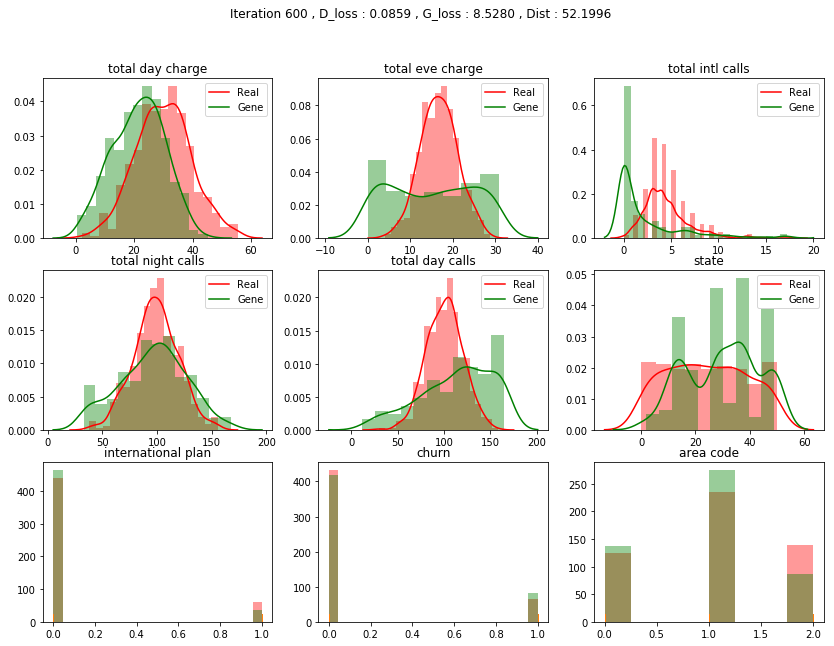

In [ ]:
if __name__ == "__main__" :
    imgs = main()

* 흥미로운점은 Species 같은 경우 [-1 , 0 , 1 ] 로 minmax scaling을 한 다음에 생성을 시킴
    * 생성물은 -1 , 1 사이에서 데이터를 생성후 Round를 하여서 사용함.
    * 그래서 기대하는 것은 생성되는 것이 수치형으로 나오지만 -1 , 0 , 1 주변으로 모이면서 생성되는 것을 기대함.
    * 실제 결과도 -1 , 0 , 1 주변으로 모이는 것이 확인함.
* softmax로 생성시
    * 문제가 생기는 것은 3클래스를 생성시키는 것을 원하는데 2가지 클래스나 1개 클래스만 생성되는 경우가 지속적으로 발생함.
    * 흔히 논문에서는 wgan을 활용해서하면, 효과가 좋다고 이야기하고 있어서 진행중
    * **발견!** 선형과 섞어주니까 좀 더 고르게 나오게 되는듯
        * 더 깊게해도 잘 될까?

In [ ]:
os.system('convert -delay 30 -loop 0 %s ./gan_Chrun_result/simulation.gif' % ' '.join(imgs))

In [ ]:
#import os
#os.system('convert -delay 30 -loop 0 ./gan_Chrun_result/*png ./gan_Chrun_result/simulation.gif')

In [ ]:
#x_plot
#g_plot = sess.run(G_sample)
##g_plot[:,:4] = scaler.inverse_transform(g_plot[:,:4])
#g_plot = np.concatenate((g_plot[:,:4] , np.argmax(g_plot[:,4:],1)[:,np.newaxis] ), axis = 1)

```
fig, ax = plt.subplots(3,4, figsize=(14, 10))
axx = ax.flatten()
num = 0
total_dist = 0
for i in [0,1,2] :
    real_idx = x_plot[:,4] == i
    fake_idx = g_plot[:,4] == i 
    dist = 0
    for n in np.arange(4) :
        try :
            dist += was_dist(x_plot[real_idx,n], g_plot[fake_idx,n])
            total_dist += dist 
        except Exception as e :
            pass
        sns.distplot(x_plot[real_idx,n], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
        sns.distplot(g_plot[fake_idx,n], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
        axx[num].set_title("{} , {}".format(i , feature[n]))
        num +=1
plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
plt.show()
```